In [80]:
import numpy as np
import pandas as pd
import ipdb
import pickle
import nnkcde
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band
from scipy.stats import norm, multivariate_normal
from scipy.integrate import simps
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from scipy.special import expit, logit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from copy import copy

from matplotlib.ticker import NullFormatter
import seaborn as sns

# omitted variable bias
# $Y \sim N(X+Z,\ \ 1)$
# $X,Z \sim N(0,1),\ \ \textrm{corr}(X,Z) = \rho$

In [2]:
def sample_X_Y_Z(rho=0.1, size=10000, var1=1, std2=1):
    joint_data = multivariate_normal.rvs(mean=[0,0], cov=var1*np.array([[1,rho],[rho,1]]), size=size)
    X_data = joint_data[:,0]
    Z_data = joint_data[:,1]
    Y_data = np.random.normal(loc=X_data+Z_data, scale=std2)
    return X_data, Y_data, Z_data

In [3]:
def get_true_conditional_dist(X, Z, std=1):
    dist = norm(loc=X+Z, scale=std)
    return dist

In [4]:
# sample points
rho = -0.2
size = 100000
X_data, Y_data, Z_data = sample_X_Y_Z(rho=rho, size=size)

# fit correct NNKCDE

In [5]:
cutoff_idx = 60000
XZ_train = np.array([[x,z] for x,z in zip(X_data[:cutoff_idx], Z_data[:cutoff_idx])])
XZ_test = np.array([[x,z] for x,z in zip(X_data[cutoff_idx:], Z_data[cutoff_idx:])])
Y_train = np.array(Y_data[:cutoff_idx])
Y_test = np.array(Y_data[cutoff_idx:])

In [95]:
k = 50
bandwidth = 0.5
model = nnkcde.NNKCDE(k=k)
model.fit(x_train=XZ_train, z_train=Y_train)

In [96]:
model.predict(np.array([[1,-1]]), np.array([0]), bandwidth=bandwidth)

array([[0.40244131]])

In [97]:
%%time

n_grid = 101
bandwidth = 0.5
z_grid = np.linspace(-10, 10, n_grid)

cde_test = model.predict(XZ_test, z_grid, bandwidth=bandwidth)

Wall time: 10.1 s


In [98]:
cde_test.shape

(40000, 101)

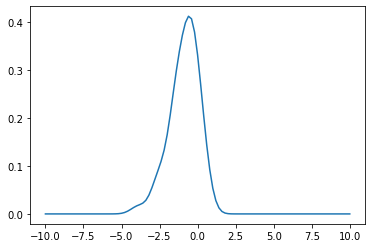

In [99]:
plt.plot(z_grid, cde_test[0])

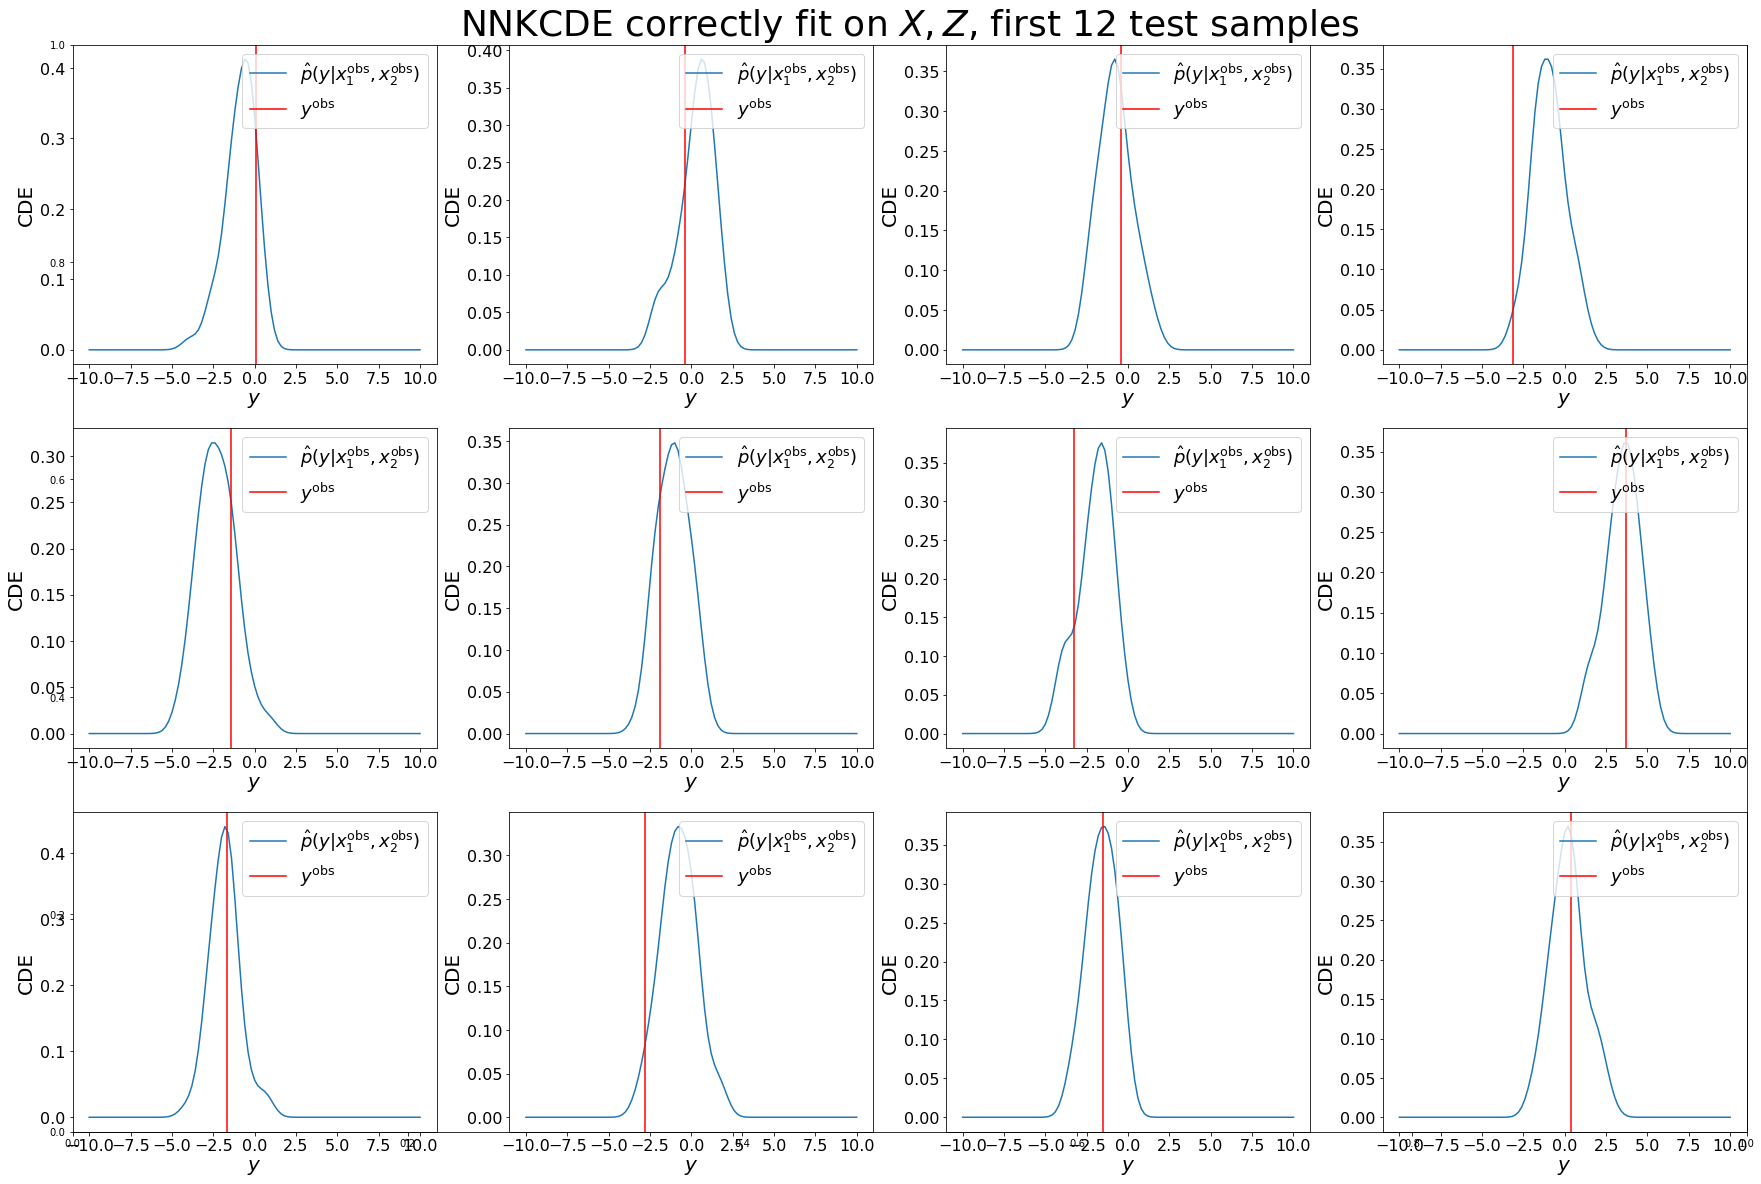

In [106]:
fig = plt.figure(figsize=(30, 20))
plt.title("NNKCDE correctly fit on $X,Z$, first 12 test samples", fontsize=36)
for jj, cde_predicted in enumerate(cde_test[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_predicted, label=r'$\hat{p}(y| x_1^{\rm obs}, x_2^{\rm obs})$')
    plt.axvline(Y_test[jj], color='red', label=r'$y^{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'$y$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 18})
plt.show()

In [101]:
print(type(cde_test), cde_test.shape)

den_integral = simps(cde_test[0, :], x=z_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (40000, 101)
Integral of the first density integrates to: 1.00


# fit incorrect NNKCDEs

In [13]:
cutoff_idx = 60000
X_train = np.array(X_data[:cutoff_idx])
X_test = np.array(X_data[cutoff_idx:])
Y_train = np.array(Y_data[:cutoff_idx])
Y_test = np.array(Y_data[cutoff_idx:])

In [102]:
k = 50
bandwidth = 0.5
model_X = nnkcde.NNKCDE(k=k)
model_X.fit(x_train=X_train, z_train=Y_train)

In [103]:
n_grid = 101
bandwidth = 0.5
z_grid = np.linspace(-10, 10, n_grid)

In [104]:
%%time

cde_test_X = model_X.predict(X_test, z_grid, bandwidth=bandwidth)

Wall time: 8.83 s


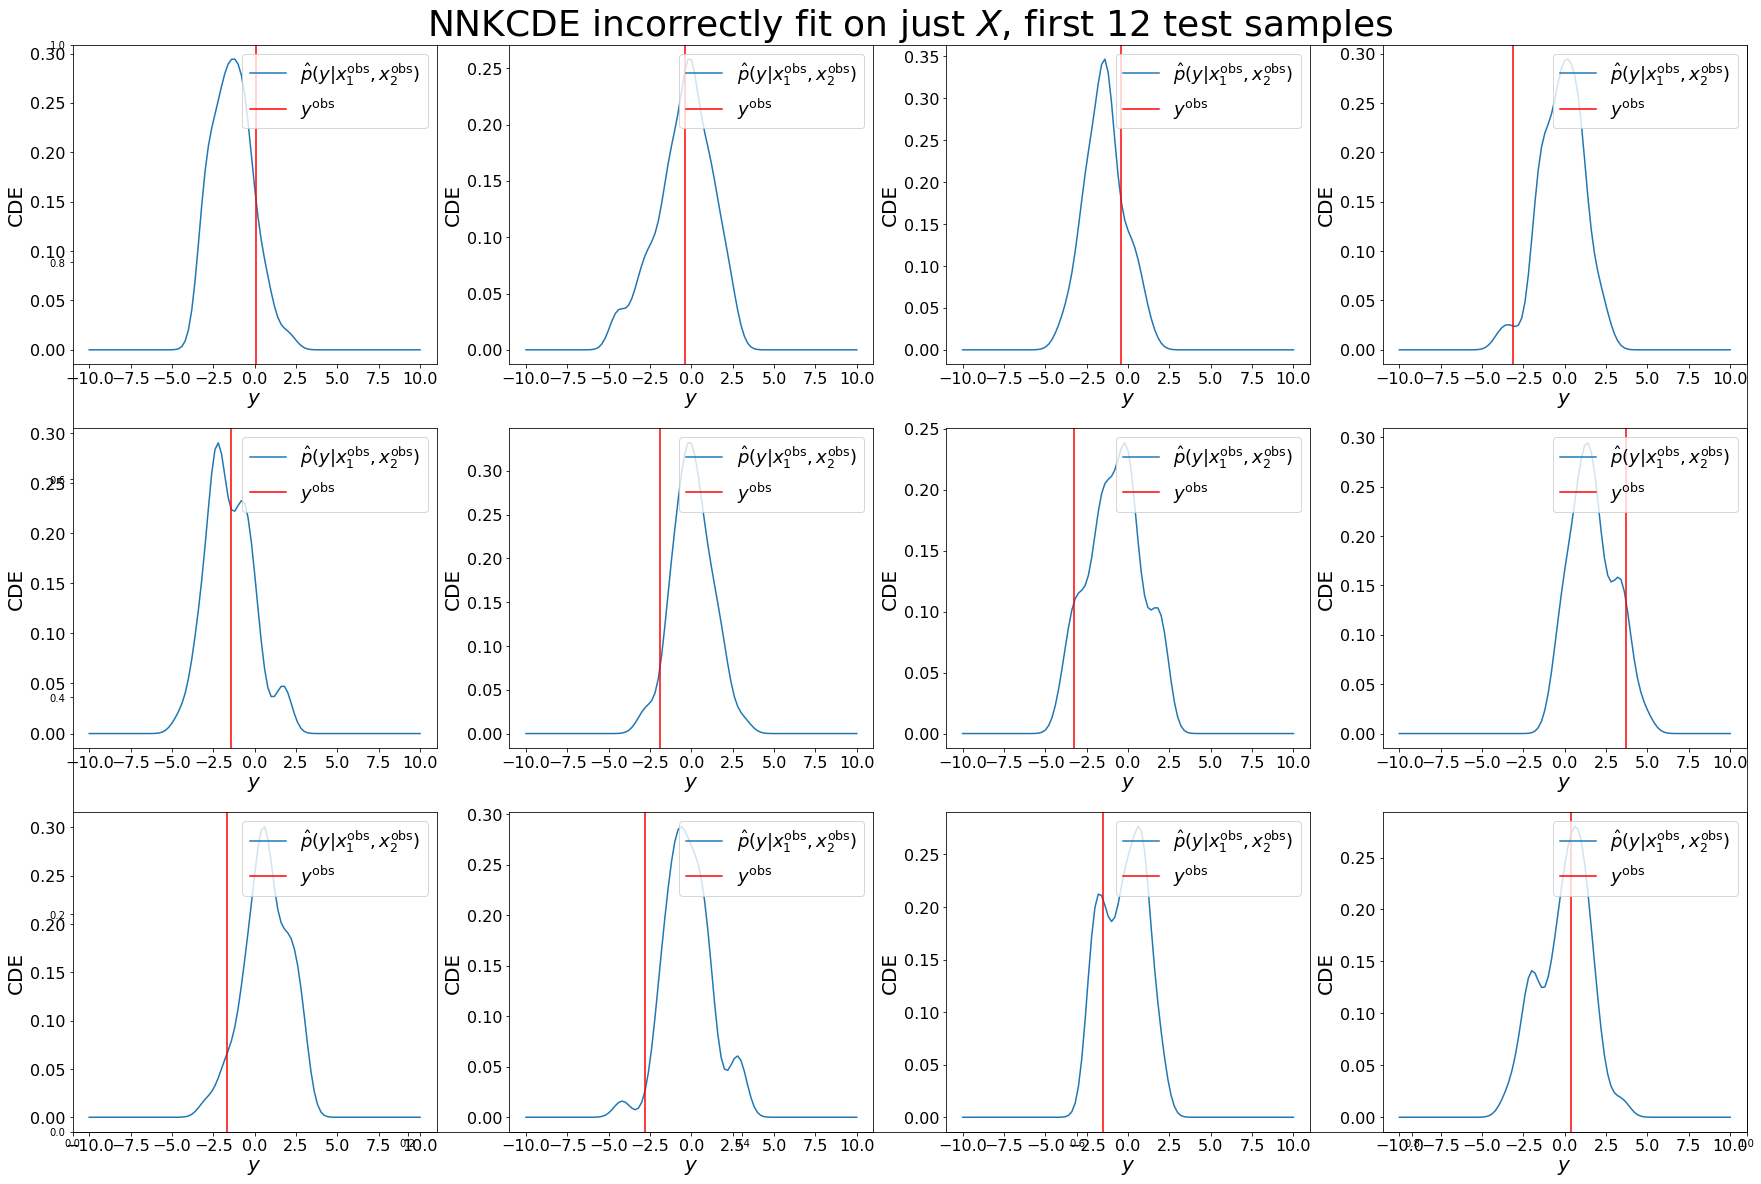

In [109]:
fig = plt.figure(figsize=(30, 20))
plt.title("NNKCDE incorrectly fit on just $X$, first 12 test samples", fontsize=36)
for jj, cde_predicted in enumerate(cde_test_X[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_predicted, label=r'$\hat{p}(y| x_1^{\rm obs}, x_2^{\rm obs})$')
    plt.axvline(Y_test[jj], color='red', label=r'$y^{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'$y$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 18})
plt.show()

In [110]:
print(type(cde_test_X), cde_test_X.shape)

den_integral = simps(cde_test_X[0, :], x=z_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (40000, 101)
Integral of the first density integrates to: 1.00


# PIT uniformity test: all NNKCDEs pass

In [111]:
pit_values = cdf_coverage(cde_test, z_grid, Y_test)
pit_values_X = cdf_coverage(cde_test_X, z_grid, Y_test)

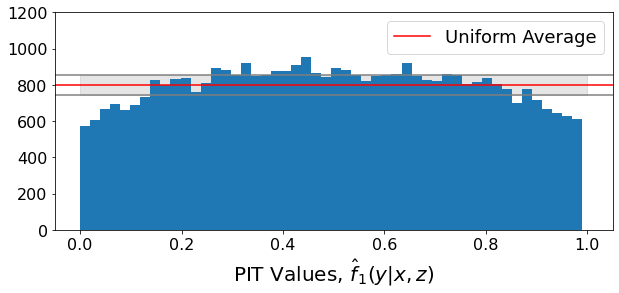

In [120]:
fig_pit = plot_with_uniform_band(values=pit_values, ci_level=0.95, x_label='PIT Values, $\hat f_1(y|x,z)$', n_bins=50, ylim=[0, 1200])
fig_pit

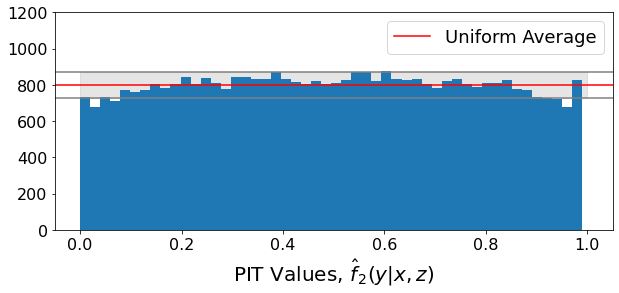

In [119]:
fig_pit = plot_with_uniform_band(values=pit_values_X, ci_level=0.99, x_label='PIT Values, $\hat f_2(y|x,z)$', n_bins=50, ylim=[0, 1200])
fig_pit

In [234]:
#with open('pit_values_dict_20210205.pkl', 'wb') as handle:
#    pickle.dump(pit_values_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [239]:
#np.save('XZ_test.npy', XZ_test)

# saved $\hat r$ from MC samples, to build CIs

In [38]:
with open("all_rhat_classifiers_2021-02-06-13-58.pkl", 'rb') as handle:
    all_rhat_classifiers = pickle.load(handle)

C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [156]:
def get_confidence_band_range(n_trials=100, name='XZ', alpha=0.05, points=[[1,2]]):
    sample = [all_rhat_classifiers[i][name][alpha].predict_proba(points)[:, 1][0] for i in range(n_trials)]
    return [min(sample), max(sample)]

# fixed $\alpha$, coverage heatmap

In [121]:
alpha = 0.2

In [122]:
x_range = np.linspace(-2,2,41)
x, z = np.meshgrid(x_range, x_range)
grid = np.hstack([x.ravel().reshape(-1,1), z.ravel().reshape(-1,1)])
x_range_round = [round(x,1) for x in x_range]

In [123]:
ind_pit_values = [1*(x<=alpha) for x in pit_values]
ind_pit_values_X = [1*(x<=alpha) for x in pit_values_X]

In [26]:
rhat_alpha = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha.fit(X=XZ_test, y=ind_pit_values)

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=25000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [27]:
rhat_alpha_X = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha_X.fit(X=XZ_test, y=ind_pit_values_X)

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=25000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [28]:
alpha_pred = rhat_alpha.predict_proba(grid)[:, 1]
alpha_pred_X = rhat_alpha_X.predict_proba(grid)[:, 1]

In [159]:
confidence_fixedalpha = {}
confidence_fixedalpha['XZ'] = np.array([get_confidence_band_range(name='XZ', alpha=alpha, points=[grid[i]])
                                          for i in range(len(grid))])
confidence_fixedalpha['X'] = np.array([get_confidence_band_range(name='X', alpha=alpha, points=[grid[i]])
                                        for i in range(len(grid))])

In [ ]:
fixedalpha_within_null = {}
fixedalpha_within_null['XZ'] = np.array([1 * (alpha_pred[i] < confidence_fixedalpha['XZ'][i][0]
          or alpha_pred[i] > confidence_fixedalpha['XZ'][i][1]) for i in range(len(alpha_pred))])
fixedalpha_within_null['X'] = np.array([1 * (alpha_pred_x1[i] < confidence_fixedalpha['X'][i][0]
          or alpha_pred_x1[i] > confidence_fixedalpha['X'][i][1]) for i in range(len(alpha_pred))])

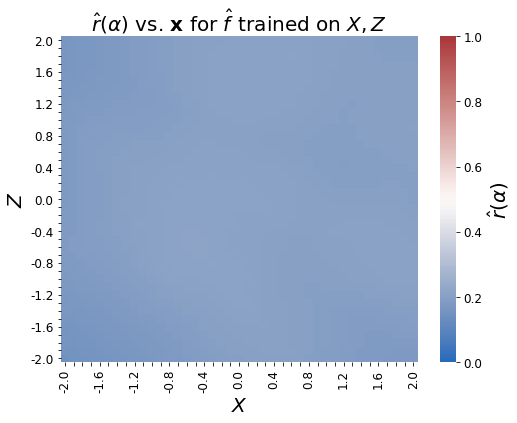

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred.reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f$ trained on $X,Z$", fontsize=20)
plt.xlabel('$X$', fontsize=20)
plt.ylabel('$Z$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

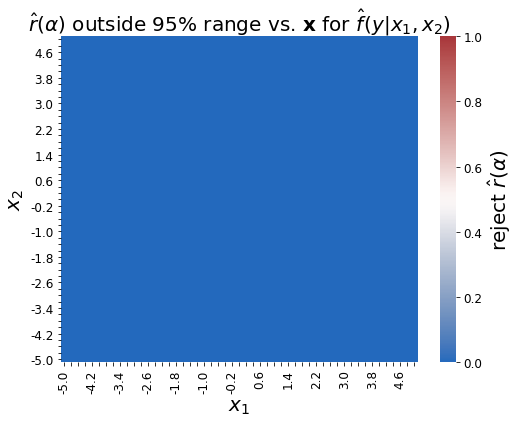

In [167]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['x1x2'].reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f$ trained on $X,Z$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

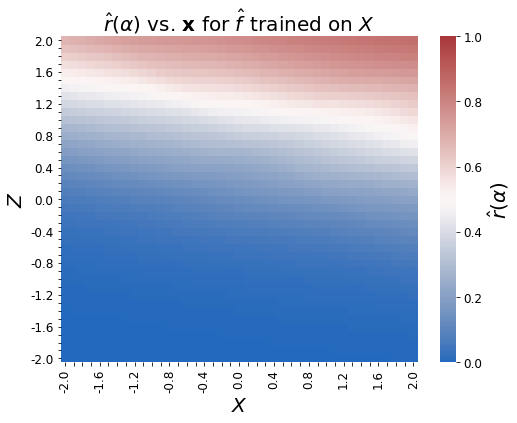

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred_X.reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f$ trained on $X$", fontsize=20)
plt.xlabel('$X$', fontsize=20)
plt.ylabel('$Z$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['X'].reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f$ trained on $X$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# fixed $\mathbf{x}_i$, QQ plot of $\hat r_\alpha(\mathbf{x}_i)$ vs. $\alpha$

In [88]:
x = -0.4
z = 0
points = np.array([[x,z]])

In [89]:
alphas = np.linspace(0.01, 0.99, 99)
pit_values_dict = {'XZ': pit_values, 'X': pit_values_X}

In [90]:
rhat_alphas_xi = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    rhat_alphas_xi[name] = {}
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x<=alpha) for x in pit]
        rhat = MLPClassifier(alpha=0, max_iter=25000)
        rhat.fit(X=XZ_test, y=ind_values)
        rhat_alphas_xi[name][alpha] = rhat.predict_proba(points)[:, 1][0]
rhat_alphas_xi = pd.DataFrame(rhat_alphas_xi)

working on classifier XZ
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97
0.98
0.99
working on classifier X
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.

In [172]:
confidence_qqplot = {}
confidence_qqplot['XZ'] = np.array([get_confidence_band_range(name='XZ', alpha=i, points=points) for i in alphas])
confidence_qqplot['X'] = np.array([get_confidence_band_range(name='X', alpha=i, points=points) for i in alphas])

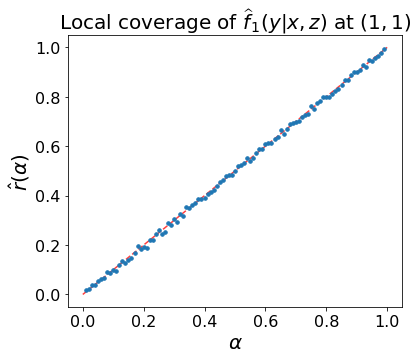

In [60]:
rhat_alphas_xi['XZ'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['XZ'].index,
                 confidence_qqplot['XZ'][:, 0],
                 confidence_qqplot['XZ'][:, 1],
                 alpha=0.15
                )
"""

plt.title("Local coverage of $\widehat f_1(y|x,z)$ at $(1,1)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

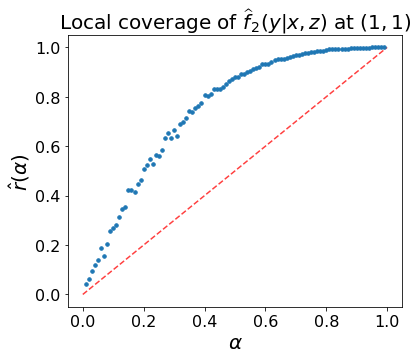

In [59]:
rhat_alphas_xi['X'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['X'].index,
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )
"""

plt.title("Local coverage of $\widehat f_2(y|x,z)$ at $(1,1)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

In [61]:
#with open('rhat_alphas_xi_20210206_1_1.pkl', 'wb') as handle:
#    pickle.dump(rhat_alphas_xi, handle, protocol=pickle.HIGHEST_PROTOCOL)

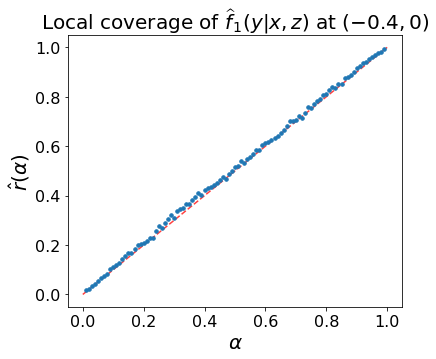

In [93]:
rhat_alphas_xi['XZ'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['XZ'].index,
                 confidence_qqplot['XZ'][:, 0],
                 confidence_qqplot['XZ'][:, 1],
                 alpha=0.15
                )
"""

plt.title("Local coverage of $\widehat f_1(y|x,z)$ at $(-0.4,0)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

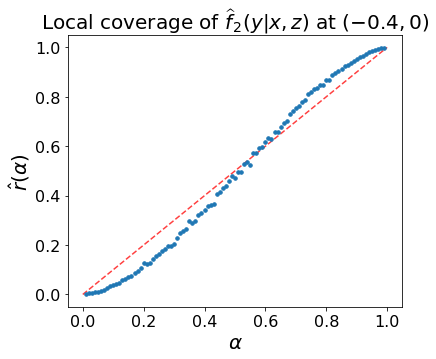

In [94]:
rhat_alphas_xi['X'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['X'].index,
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )
"""

plt.title("Local coverage of $\widehat f_2(y|x,z)$ at $(-0.4,0)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

In [67]:
#with open('rhat_alphas_xi_20210206_0_0.pkl', 'wb') as handle:
#    pickle.dump(rhat_alphas_xi, handle, protocol=pickle.HIGHEST_PROTOCOL)

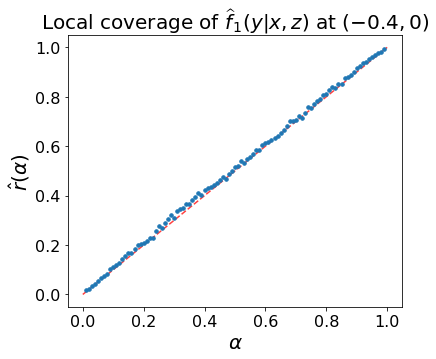

In [91]:
rhat_alphas_xi['XZ'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['XZ'].index,
                 confidence_qqplot['XZ'][:, 0],
                 confidence_qqplot['XZ'][:, 1],
                 alpha=0.15
                )
"""

plt.title("Local coverage of $\widehat f_1(y|x,z)$ at $(-0.4,0)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

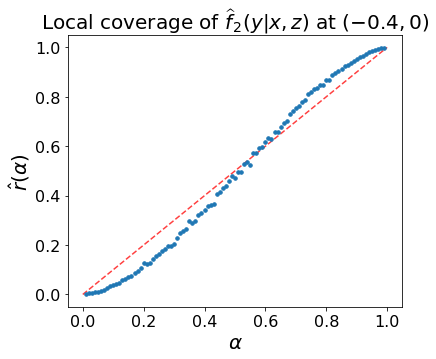

In [92]:
rhat_alphas_xi['X'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['X'].index,
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )
"""

plt.title("Local coverage of $\widehat f_2(y|x,z)$ at $(-0.4,0)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

In [ ]:
with open('rhat_alphas_xi_20210206_-0.4_0.pkl', 'wb') as handle:
    pickle.dump(rhat_alphas_xi, handle, protocol=pickle.HIGHEST_PROTOCOL)

# heat map of $T_i = \frac{1}{|G|} \sum_{\alpha \in G} (\hat r_\alpha(\mathbf{x}_i) - \alpha)^2$

In [36]:
with open('Ti_values_2021-02-05-20-34.pkl', 'rb') as handle:
    Ti_values = pickle.load(handle)
with open('all_rhat_alphas_2021-02-05-20-34.pkl', 'rb') as handle:
    all_rhat_alphas = pickle.load(handle)

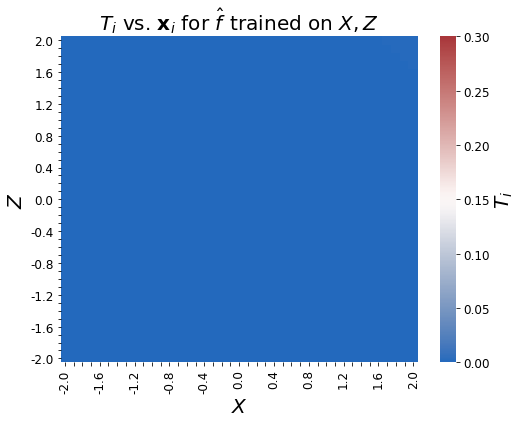

In [44]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['XZ'].values.reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f$ trained on $X,Z$", fontsize=20)
plt.xlabel('$X$', fontsize=20)
plt.ylabel('$Z$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

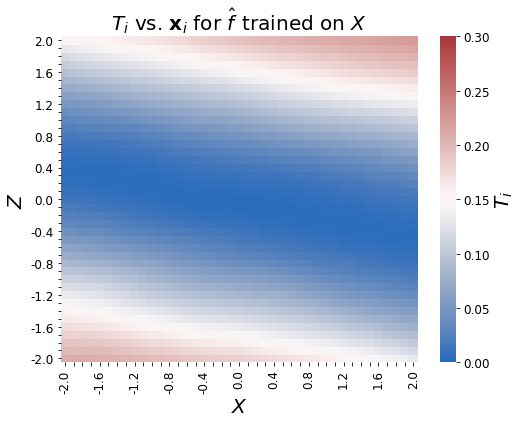

In [45]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['X'].values.reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f$ trained on $X$", fontsize=20)
plt.xlabel('$X$', fontsize=20)
plt.ylabel('$Z$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# global p-value based on $T_i$

In [47]:
global_pvalues = sum([1* (pd.DataFrame(Ti_values).mean() < pd.DataFrame(all_unif_Ti_values[i]).mean())
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
global_pvalues

XZ    0.053
X     0.000
dtype: float64

# local p-values based on $T_i$: local CvM test

In [48]:
all_rhat_classifiers[0]['XZ']

{0.1: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_start=False),
 0.2: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_

In [50]:
all_rhat_classifiers[0]['XZ'][0.1].predict_proba([[1,2]])

array([[0.91847467, 0.08152533]])

In [40]:
with open("all_unif_Ti_values_2021-02-06-13-58.pkl", 'rb') as handle:
    all_unif_Ti_values = pickle.load(handle)

In [51]:
all_pvalues = sum([1* (pd.DataFrame(Ti_values) < pd.DataFrame(all_unif_Ti_values[i]))
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
all_pvalues

,XZ,X
0,0.224,0.0
1,0.300,0.0
2,0.405,0.0
3,0.517,0.0
4,0.627,0.0
...,...,...
1676,0.055,0.0
1677,0.053,0.0
1678,0.045,0.0
1679,0.038,0.0


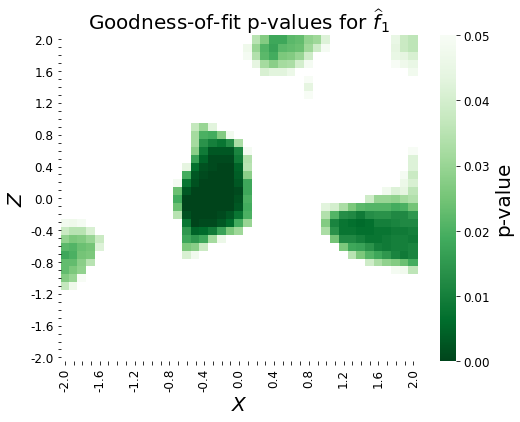

In [87]:
fig, ax = plt.subplots(figsize=(8,6))
val_max = 0.05
#define the colormap with clipping values
my_cmap = copy(plt.cm.Greens_r)
my_cmap.set_over("white")
sns.heatmap(all_pvalues['XZ'].values.reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap=my_cmap, vmin=0, vmax=val_max)#vmax=1)
ax.invert_yaxis()

plt.title("Goodness-of-fit p-values for $\widehat f_1$", fontsize=20)
plt.xlabel('$X$', fontsize=20)
plt.ylabel('$Z$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

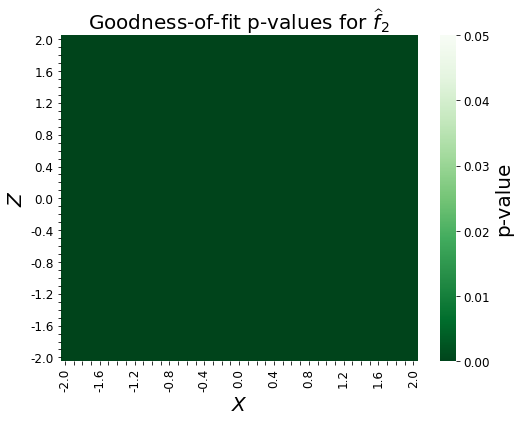

In [86]:
fig, ax = plt.subplots(figsize=(8,6))
val_max = 0.05
#define the colormap with clipping values
my_cmap = copy(plt.cm.Greens_r)
my_cmap.set_over("white")
sns.heatmap(all_pvalues['X'].values.reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap=my_cmap, vmin=0, vmax=val_max)#vmax=1)
ax.invert_yaxis()

plt.title("Goodness-of-fit p-values for $\widehat f_2$", fontsize=20)
plt.xlabel('$X$', fontsize=20)
plt.ylabel('$Z$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# Benjamini-Hochberg FDR correction

In [136]:
m = 41*41
alpha = 0.05

In [137]:
bh_values = alpha * (np.arange(m) + 1) / m

In [138]:
f_type = 'x1x2'
pval_vs_bh = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh.index
pval_vs_bh_sorted = pd.Series(pval_vs_bh.values, index=np.arange(m)+1)
all_rejected_idxs = pval_vs_bh_sorted[pval_vs_bh_sorted == 1].index
last_rejected_idx = all_rejected_idxs[-1] if len(all_rejected_idxs) > 0 else 0
bh_rejections = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                          index=use_idx)

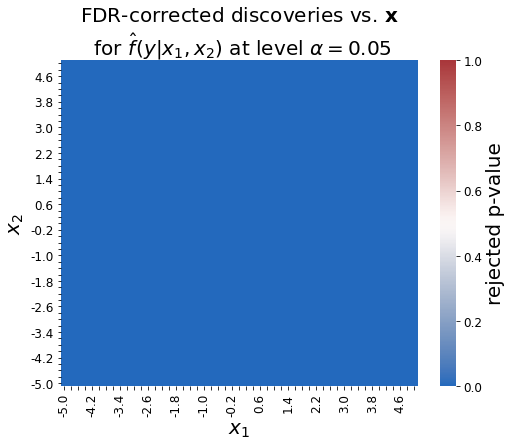

In [139]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f$ trained on $X$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [140]:
f_type = 'x1'
pval_vs_bh_x1 = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_x1.index
pval_vs_bh_x1_sorted = pd.Series(pval_vs_bh_x1.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_sorted[pval_vs_bh_x1_sorted == 1].index[-1]
bh_rejections_x1 = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                             index=use_idx)

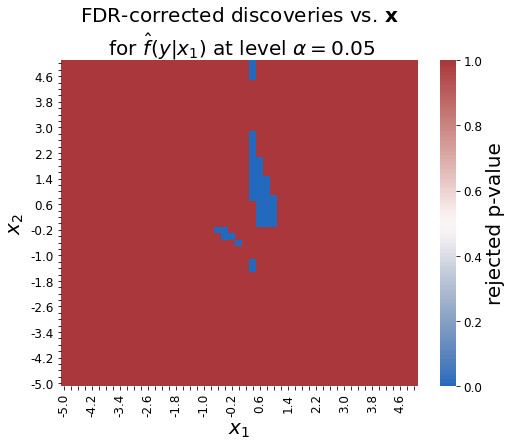

In [141]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_x1.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f$ trained on $X$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)